In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import datasets, utils, models, layers, optimizers, metrics, losses
import keras
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer

In [31]:

class DCGAN(models.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(DCGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean("d_loss")
        self.g_loss_metric = metrics.Mean("g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(generated_images, training=True)

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + 0.1 * tf.random.uniform(tf.shape(real_predictions))
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - 0.1 * tf.random.uniform(tf.shape(fake_predictions))
            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0
            g_loss = self.loss_fn(real_labels, fake_predictions)

        disc_grads = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gen_grads = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )
        self.d_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}
    
    
def discriminator_model(window_size, num_features):
    discriminator_input = layers.Input(shape=(window_size, num_features))
    x = layers.Conv1D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
        discriminator_input
    )
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv1D(
        128, kernel_size=4, strides=2, padding="same", use_bias=False
    )(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv1D(
        256, kernel_size=4, strides=2, padding="same", use_bias=False
    )(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv1D(
        1,
        kernel_size=4,
        strides=1,
        padding="valid",
        use_bias=False,
        activation="sigmoid",
    )(x)
    discriminator_output = layers.Flatten()(x)

    discriminator = models.Model(discriminator_input, discriminator_output)
    return discriminator

def generator_model(z_dim, num_features):
    generator_input = layers.Input(shape=(z_dim,))
    x = layers.Reshape((1, Z_DIM))(generator_input)
    x = layers.Conv1DTranspose(
        512, kernel_size=4, strides=1, padding="valid", use_bias=False
    )(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv1DTranspose(
        256, kernel_size=4, strides=2, padding="same", use_bias=False
    )(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv1DTranspose(
        128, kernel_size=4, strides=2, padding="same", use_bias=False
    )(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    generator_output = layers.Conv1DTranspose(
        num_features,
        kernel_size=4,
        strides=2,
        padding="same",
        use_bias=False,
        activation="tanh",
    )(x)
    generator = models.Model(generator_input, generator_output)

    return generator

In [32]:
WINDOW = 32
Z_DIM = 100

In [33]:
data = pd.read_table("../data/EURUSD_D1.csv", names=["datetime", "open", "high", "low", "close", "volume"])
data.drop("volume", inplace=True, axis=1)
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    MinMaxScaler()
)

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    verbose_feature_names_out=False
)

data = pd.DataFrame(preprocessing.fit_transform(data), columns=preprocessing.get_feature_names_out())

num_data = data.select_dtypes(include="number")
windows = np.array(list(num_data.rolling(window=WINDOW))[WINDOW:])

In [34]:
dcgan = DCGAN(generator_model(Z_DIM, 4), discriminator_model(WINDOW, 4), Z_DIM)

In [35]:
dcgan.compile(
    optimizers.Adam(learning_rate=0.0002),
    optimizers.Adam(learning_rate=0.0002)
)

In [75]:
dcgan.fit(windows, epochs=1000)

Epoch 1/1000
156/156 [==============================] - 3s 19ms/step - d_loss: 0.5541 - g_loss: 0.9384
Epoch 2/1000
156/156 [==============================] - 3s 19ms/step - d_loss: 0.6352 - g_loss: 0.8460
Epoch 3/1000
156/156 [==============================] - 3s 18ms/step - d_loss: 0.6843 - g_loss: 0.7925
Epoch 4/1000
156/156 [==============================] - 3s 19ms/step - d_loss: 0.6071 - g_loss: 0.8817
Epoch 5/1000
156/156 [==============================] - 3s 18ms/step - d_loss: 0.6156 - g_loss: 0.8628
Epoch 6/1000
156/156 [==============================] - 3s 18ms/step - d_loss: 0.6791 - g_loss: 0.8216
Epoch 7/1000
156/156 [==============================] - 3s 18ms/step - d_loss: 0.5893 - g_loss: 0.9421
Epoch 8/1000
156/156 [==============================] - 3s 18ms/step - d_loss: 0.6557 - g_loss: 0.7844
Epoch 9/1000
156/156 [==============================] - 3s 20ms/step - d_loss: 0.6482 - g_loss: 0.8589
Epoch 10/1000
156/156 [==============================] - 3s 18ms/step - d

In [76]:
dcgan.save_weights("dcgan_window_32.h5")

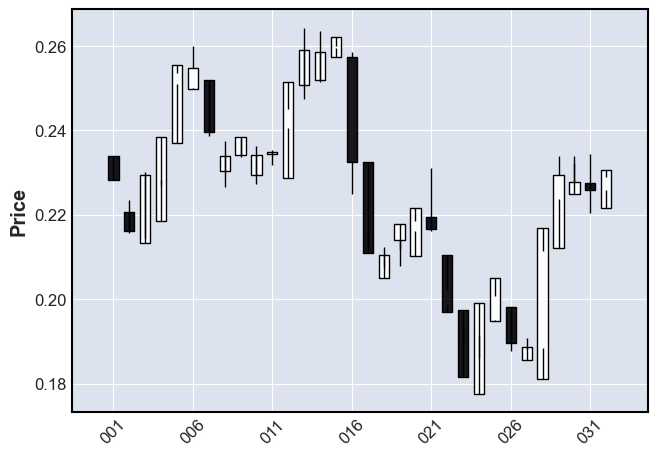

In [90]:
random_latent_vector = np.random.normal(
            size=(1, 100)
        )
generated_data = pd.DataFrame(dcgan.generator(random_latent_vector)[0], columns=["open", "high", "low", "close"])
generated_data.index = pd.date_range('1/1/2021',periods=(generated_data.shape[0]))
mpf.plot(generated_data, type='candle', datetime_format='%j')

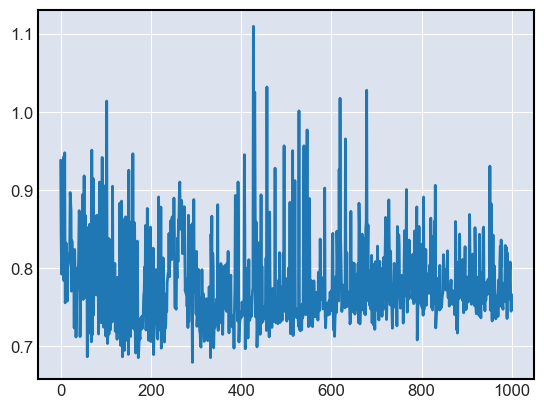

In [82]:
plt.plot(dcgan.history.history["g_loss"])

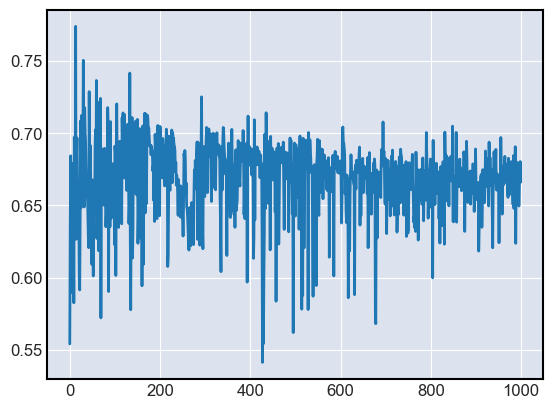

In [83]:
plt.plot(dcgan.history.history["d_loss"])